In [381]:
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
from os import walk

from scipy.signal import find_peaks
from IPython.display import display, Markdown, Latex

# Custom Imports
import helpers

In [83]:
importlib.reload(helpers)

<module 'helpers' from '/Users/ryankim/Documents/CodeProjects/eeg_blink_calibration/helpers.py'>

In [405]:
class Participant:
    
    def __init__(self, data_dir, correct_calibrations):
        # Variables
        self.data_dir = data_dir
        self.correct_calibrations = correct_calibrations
        
        # Preprocessed data
        self.files = {}
        self.calibrations = None
        self.blinks = { 'eeg':None, 'vr': None }
        self.eeg = { 
            'rest': { 'signals': None, 'raw':None, 'calculated':None, 'mind_monitor':None }, 
            'vr': { 'signals': None, 'raw':None, 'calculated':None, 'mind_monitor':None } 
        }
        self.trials = None
        
        # Initialize
        self.initialize()
    
    """
    * Desc: Parent function - usually called at the beginning, when this class instance is created.
    * Goal: Read all files and calculate the trials for the current participant.
    """
    def initialize(self):
        self.read_data_dir()
        self.read_files()
        self.determine_trials()
        return self
    
    """
    * Desc: Read all the files in a participant's directory
    * Goal: populate `self.files`
    """
    def read_data_dir(self):
        # Read all files
        fs = next(walk(_DATA_DIR), (None, None, []))[2]  # [] if no file
        self.files['all'] = [f for f in fs if f != '.DS_Store']
        
        # Extract each file type
        self.files['eeg_vr'] = 'eeg_vr.csv' if 'eeg_vr.csv' in self.files['all'] else None
        self.files['eeg_rest'] = 'eeg_rest.csv' if 'eeg_rest.csv' in self.files['all'] else None
        self.files['eye'] = 'eye.csv' if 'eye.csv' in self.files['all'] else None
        self.files['pedestrians'] = 'pedestrians.csv' if 'pedestrians.csv' in self.files['all'] else None
        self.files['calibrations'] = [f for f in self.files['all'] if f.startswith('calibration')]
        if len(self.files['calibrations']) == 0: self.files['calibrations'] = None
        
        # Return self
        return self
    
    """
    * Desc: Parent function - after getting all data files, read each of them
    * Goal: Read throuhg all calibration files, eeg files, etc.
    """
    def read_files(self):
        self.read_calibrations()
        self.read_eeg()
        self.read_eye()
        return self
    
    """
    * Desc: Read all calibration files; each participant should ideally come with 7 files, for each trial
    * Goal: Concatenate all calibration files into a combined repository.
    """
    def read_calibrations(self):
        # Return if None or if the list of files is empty
        if self.files['calibrations'] is None or len(self.files['calibrations'])==0:
            self.calibrations = None
            return self
        
        # Look at each calibration file, append to a combined `cals` array
        cals = []
        for i in range(len(self.files['calibrations'])):
            # Read raw DF
            file = self.files['calibrations'][i]
            f = os.path.join(self.data_dir, self.files['calibrations'][i])
            df = pd.read_csv(f);
            
            # Check if we need to correct.
            if self.correct_calibrations:
                df = self.correct_calibration(df)
            
            # Append the trial number to the dataframe
            df['trial'] = i
            
            # Append the dataframe to our list of calibrations
            cals.append(df)
            
        # Concat the claibration files
        self.calibrations = pd.concat(cals)
            
        # Extract overlaps to generate VR blinks
        self.blinks['vr'] = self.calibrations[self.calibrations['event'] == 'Overlap']
        
        return self
    
    """
    * Desc: Helper function - called by `read_calibrations()` to correct trials that suffered from multiple `unix_ms` columns
    * Goal: Return a calibration file that doesn't feature the duplicate columns
    """
    def correct_calibration(self, 
                            df, 
                            cols=['unix_ms', 'frame', 'rel_timestamp', 'event', 'overlap_counter'] ):
        # Only keep the first N number of columns defined by cols
        df2 = df.iloc[:, :len(cols)]
        # Then rename the cols
        df2.columns = cols
        # Return the new dataframe
        return df2
    
    """
    * Desc: Reads the EEG files, dividing them between signals as-is, raw signals, and mind monitor PSDs
    * Goal: Populate `self.eeg` for both rest and vr conditions
    """
    def read_eeg(self):
        # Read the rest data
        rest_signals, _ = helpers.read_muse(os.path.join(self.data_dir, self.files['eeg_rest']))
        rest_raw, rest_mm = helpers.separate_eeg(rest_signals)
        self.eeg['rest']['signals'] = rest_signals
        self.eeg['rest']['raw'] = rest_raw
        self.eeg['rest']['mind_monitor'] = rest_mm
        
        # Read the VR data
        vr_signals, vr_blinks = helpers.read_muse(os.path.join(self.data_dir, self.files['eeg_vr']))
        vr_raw, vr_mm = helpers.separate_eeg(vr_signals)
        self.eeg['vr']['signals'] = vr_signals
        self.eeg['vr']['raw'] = vr_raw
        self.eeg['vr']['mind_monitor'] = vr_mm
        
        # Get the blink
        self.blinks['eeg'] = vr_blinks
        
        # return self
        return self
    
    """
    * Desc: Reads
    """
    def read_eye(self):
        eye_df = pd.read_csv(os.path.join(self.data_dir, self.files['eye']))
        eye_mask = eye_df['event'].isin(["Calibration", "Activation", "Trial-ApproachAudio Start", "Trial-BehindAudio Start", "Trial-Behind Start", "Trial-AlleyRunnerAudio Start", "Trial-AlleyRunner Start", "Trial-Approach Start"])
        self.eye = eye_df[~eye_mask]
        return self
    
    def determine_trials(self):
        
        # We intuit the trials from the calibration files.
        # The start of each trial is provided whenever `event` == 'Start' in self.calibrations
        # The end of each trial is the start of the next calibration event.
        
        # First, generate a trial bounds for each trial
        calibration_starts = self.calibrations[self.calibrations['event'] == 'Start']
        trial_bounds = pd.DataFrame({
            'trial_id': calibration_starts['trial'],
            'trial_start_unix_ms': calibration_starts['unix_ms'],
            # shift(-1) moves the next trial's timestamp up one row
            'trial_end_unix_ms': calibration_starts['unix_ms'].shift(-1),
        })
        # The only caveat is the last trial, which doesn't have a following calibration file.
        # For that one, we just use the last timestamp afforded by our eeg data.
        trial_bounds.loc[trial_bounds['trial_end_unix_ms'].isna(), 'trial_end_unix_ms'] = self.eeg['vr']['raw']['unix_ms'].iloc[-1]
        
        # Secondly, generate the calibration bounds for each trial
        calibration_rows = self.calibrations[self.calibrations['event'].isin(['Start','End'])]
        calibrations_wide = calibration_rows.pivot(index='trial', columns='event', values='unix_ms')
        calibration_bounds = calibrations_wide.rename(columns={
            'Start': 'cal_start_unix_ms',
            'End': 'cal_end_unix_ms'
        }).reset_index()
        
        # Combine via a left join
        self.trials = pd.merge(
            left=trial_bounds, 
            right=calibration_bounds,
            how='left',
            left_on='trial_id',
            right_on='trial')
        self.trials.drop(columns=['trial'], inplace=True)
        
        # return self
        return self
    
    def calculate_vr_eeg_diff(self):
        # The assumption here
        return self
    
    def render_timelapse(self, 
                        channels=['AF7','AF8','TP9','TP10'],
                        channel_colors=['red','green','lightblue','purple'],
                        eeg_blink_color='black',
                        vr_blink_color='blue',
                        time_col='unix_ms', 
                        trial_id=None,
                        calibration_only=False,
                        figsize=(15,7.5) ):
        
        # Define the plot
        fig, axes = plt.subplots(len(channels), 1, figsize=figsize)
        
        # Initialize dataframes for use in rendering
        eeg_vr = self.eeg['vr']['raw']
        eeg_blinks = self.blinks['eeg']
        vr_blinks = self.blinks['vr']
        start_unix_ms = None
        end_unix_ms = None
        
        # Isolate to a single trial if needed
        if (trial_id is not None):
            trial = self.trials[self.trials['trial_id'] == trial_id].iloc[0]
            start_unix_ms = trial['trial_start_unix_ms']
            end_unix_ms = trial['trial_end_unix_ms']
            
            # If isolated to a trial, we check if we want only `calibration_only`
            if calibration_only:
                start_unix_ms = trial['cal_start_unix_ms'] + 5000
                end_unix_ms = trial['cal_end_unix_ms']
            
        
        if (start_unix_ms is not None and end_unix_ms is not None):
            eeg_vr = eeg_vr[
                (start_unix_ms <= eeg_vr['unix_ms']) 
                & (eeg_vr['unix_ms'] < end_unix_ms) ]
            eeg_blinks = eeg_blinks[
                (start_unix_ms <= eeg_blinks['unix_ms']) 
                & (eeg_blinks['unix_ms'] < end_unix_ms) ]
            vr_blinks = vr_blinks[
                (start_unix_ms <= vr_blinks['unix_ms']) 
                & (vr_blinks['unix_ms'] < end_unix_ms) ]

        # Plot each eeg channel
        for i in range(len(channels)):
            channel = channels[i]
            channel_color = channel_colors[i]
            eeg_vr.plot(x=time_col, y=channel, c=channel_color, ax=axes[i])

        # Blinks from EEG
        for xc in eeg_blinks[time_col].tolist():
            for i in range(len(channels)):
                axes[i].axvline(x=xc, color=eeg_blink_color, linestyle='-')
        
        # Blinks from VR
        for xc in vr_blinks[time_col].tolist():
            for i in range(len(channels)):
                axes[i].axvline(x=xc, color=vr_blink_color, linestyle='-')

        plt.show()
        return self
    
    def render_eye_head_diff(self, 
                             trial_id=None,
                             calibration_only=False,
                             include_blinks=False,
                             eeg_blink_color='black',
                             vr_blink_color='blue',
                             time_col='unix_ms', 
                             figsize=(20,5),
                             ylim=None,
                             detect_peaks=False ):
        # Preliminary eye_df from self.eye
        eye_df = self.eye
        eeg_blinks = None
        vr_blinks = None
        start_unix_ms = None
        end_unix_ms = None
        
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        
        # if the trial_id is provided, only use the trial corresponding to that ID
        if trial_id is not None:
            trial = self.trials[self.trials['trial_id'] == trial_id].iloc[0]
            start_unix_ms = trial['trial_start_unix_ms']
            end_unix_ms = trial['trial_end_unix_ms']
            
            if calibration_only:
                start_unix_ms = trial['cal_start_unix_ms'] + 5000
                end_unix_ms = trial['cal_end_unix_ms']
        
        # if we want to include blinks, then we add them
        if include_blinks:
            eeg_blinks = self.blinks['eeg']
            vr_blinks = self.blinks['vr']
        
        # Filter out irrelevant rows, and render
        if start_unix_ms is not None and end_unix_ms is not None:
            # Filter out irrelevant rows from `eye_df`
            eye_df = eye_df[
                (start_unix_ms <= eye_df['unix_ms'])
                & (eye_df['unix_ms'] < end_unix_ms)
            ]
        eye_df.plot.scatter(ax=ax, x=time_col, y='gaze_head_angle_diff', marker='.', s=50, c='orange')
        eye_df.plot(ax=ax, x=time_col, y='gaze_head_angle_diff', alpha=0.5, c='red')
        
        # If including blinks, then we also have to do the same process of row-filtering and rendering
        if eeg_blinks is not None:
            eeg_blinks = eeg_blinks[
                (start_unix_ms <= eeg_blinks['unix_ms'])
                & (eeg_blinks['unix_ms'] < end_unix_ms)
            ]
            for xc in eeg_blinks[time_col].tolist():
                ax.axvline(x=xc, color=eeg_blink_color, linestyle='-')
        
        if vr_blinks is not None:
            vr_blinks = vr_blinks[
                (start_unix_ms <= vr_blinks['unix_ms'])
                & (vr_blinks['unix_ms'] < end_unix_ms)
            ]
            for xc in vr_blinks[time_col].tolist():
                ax.axvline(x=xc, color=vr_blink_color, linestyle='-')
        
        # If we want to detect peaks, then we need to 
        #    isolate the values from `gaze_head_angle_diff` into an numpy array.
        #    Then we have to run the function `find_peaks()`
        if detect_peaks:
            # Extract the data as numpy arraysw
            diffs = np.array(eye_df['gaze_head_angle_diff'].tolist())
            timestamps = np.array(eye_df[time_col].tolist())
            # Finding peaks = just looking at the signal
            diff_peaks, _ = find_peaks(diffs, height=5, distance=20)  # at least 5 degrees beyond 0
            # Finding valleys = looking at an inverted version of the signal
            diff_valleys, _ = find_peaks(-diffs, height=-5, distance=20)
            plt.scatter(timestamps[diff_peaks], diffs[diff_peaks], marker='x', c='blue')
            plt.scatter(timestamps[diff_valleys], diffs[diff_valleys], marker='x', c='black')
        
        # show the plot
        if (ylim is not None):
            plt.ylim(ylim) 
        plt.show()
        

In [402]:
_DATA_DIR = 'data/P1/'
p1 = Participant(_DATA_DIR, True)

/Users/ryankim/Documents/CodeProjects/eeg_blink_calibration/helpers.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/ryankim/Documents/CodeProjects/eeg_blink_calibration/helpers.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


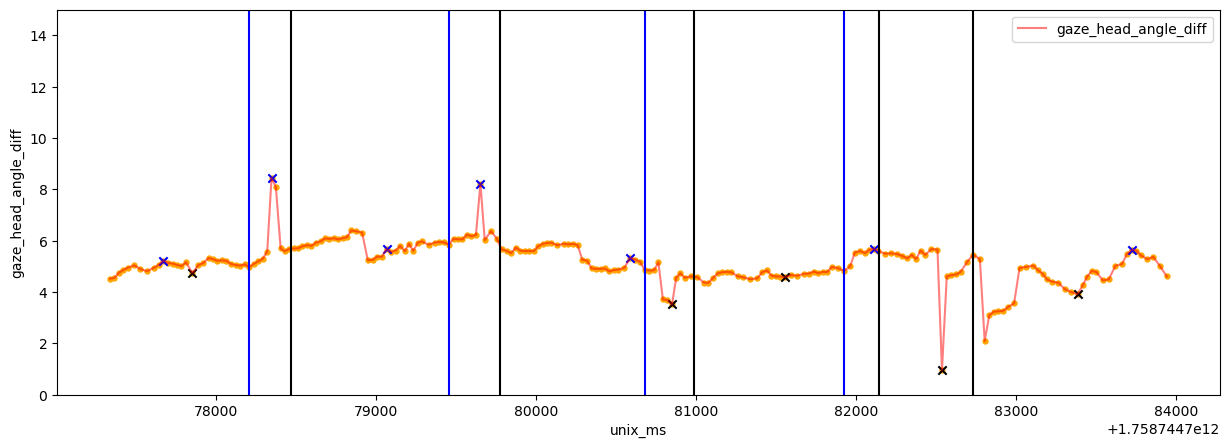

In [403]:
p1.render_eye_head_diff(trial_id=1, figsize=(15,5), calibration_only=True, include_blinks=True, ylim=(0,15), detect_peaks=True)

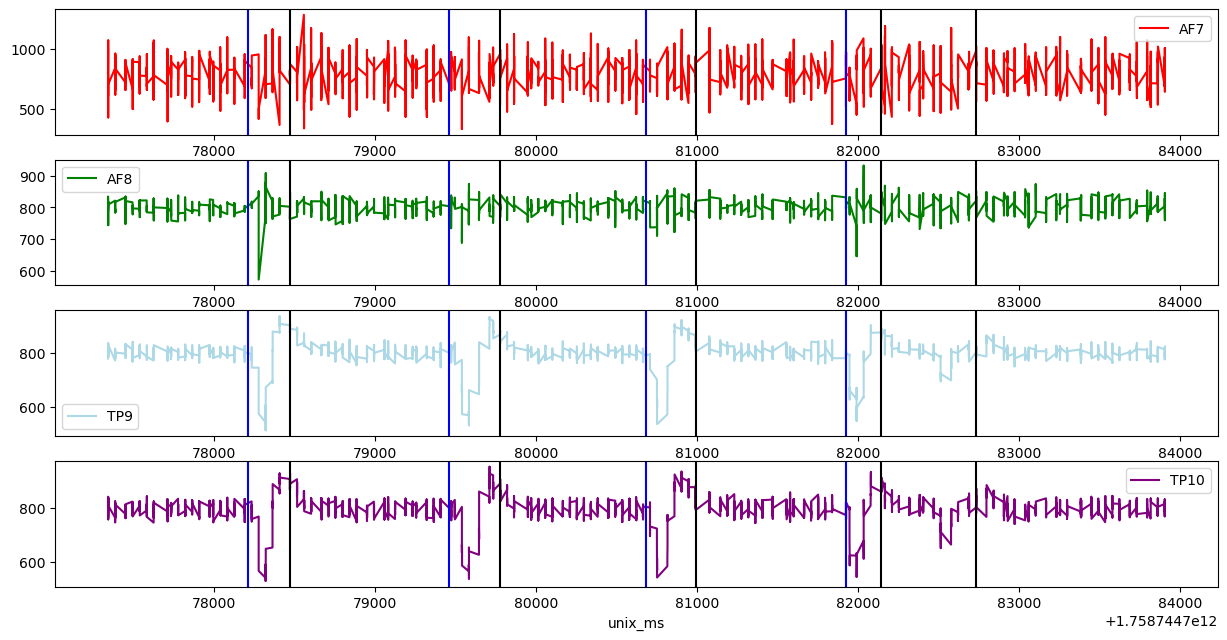

In [404]:
p1.render_timelapse(trial_id=1, calibration_only=True)

In [119]:
p1.eeg['vr']['raw']

,unix_sec,unix_ms,rel_sec,rel_ms,TP9,TP10,AF7,AF8
1,1.758745e+09,1758744725441,0.026,26,870.732601,961.794872,844.139194,811.904762
2,1.758745e+09,1758744725442,0.027,27,873.150183,960.183150,962.600733,794.175824
3,1.758745e+09,1758744725442,0.027,27,843.736264,972.271062,796.996337,799.816850
5,1.758745e+09,1758744725442,0.027,27,863.882784,987.582418,857.032967,829.230769
6,1.758745e+09,1758744725442,0.027,27,915.054945,969.450549,956.153846,838.095238
...,...,...,...,...,...,...,...,...
55588,1.758745e+09,1758744940483,215.068,215068,823.186813,836.483516,489.157509,813.113553
55589,1.758745e+09,1758744940483,215.068,215068,811.904762,828.827839,696.263736,809.890110
55590,1.758745e+09,1758744940483,215.068,215068,805.054945,803.040293,867.509158,794.578755
55591,1.758745e+09,1758744940483,215.068,215068,810.293040,809.890110,803.040293,800.219780


In [39]:
df_temp_2 = df_temp.iloc[:, :3]
df_temp_2

,Col,Col.1,Calcium
2020-01-01,10,13,17
2020-01-02,20,23,27
2020-01-03,15,18,22
2020-01-04,30,33,37
2020-01-05,45,48,52


In [42]:
known_columns = ['unix_ms', 'x', 'y']
df_temp_2.columns = known_columns
df_temp_2

,unix_ms,x,y
2020-01-01,10,13,17
2020-01-02,20,23,27
2020-01-03,15,18,22
2020-01-04,30,33,37
2020-01-05,45,48,52
